# 02 - Model Training

## I. Preliminaries

Import the libraries and functions for model training and hyperparameter search.

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
import torch

from metaboDGD.util import data, train
from metaboDGD.src import model
import seaborn as sns
plt.rcParams["font.family"] = 'Arial'

## II. Retrieve Dataframe and Cohorts

Initialize the filenames and directories of the normal and tumor sample dataframes and cohorts.

In [ ]:
dir = 'outputs/'
df_normal_fname = 'CombinedDataset_CAMP_Normal.csv'
df_tumor_fname = 'CombinedDataset_CAMP_Tumor.csv'
cohorts_fname = 'cohorts_Normal.pkl'
cohorts_tumor_fname = 'cohorts_Tumor.pkl'

Read the `.csv` and `.pkl` files to get the dataframes and cohorts, respectively.

In [ ]:
# Read the normal sample dataframe and convert to a numpy array
df_normal = pd.read_csv(dir + df_normal_fname)
df_normal.set_index('Unnamed: 0', inplace=True)
df_normal.index.name = None
np_normal_lbls = df_normal.loc['cohort'].to_numpy()
np_normal_log = df_normal.T.drop(columns=['cohort']).astype('float64').to_numpy()

# Read the tumor sample dataframe and convert to a numpy array
df_tumor = pd.read_csv(dir + df_tumor_fname)
df_tumor.set_index('Unnamed: 0', inplace=True)
df_tumor.index.name = None
np_tumor_lbls = df_tumor.loc['cohort'].to_numpy()
np_tumor_log = df_tumor.T.drop(columns=['cohort']).astype('float64').to_numpy()

# Read the normal sample cohort dictionary
fn = open(dir + cohorts_fname, 'rb')
cohorts = pickle.load(fn)
fn.close()

# Read the tumor sample cohort dictionary
ft = open(dir + cohorts_tumor_fname, 'rb')
cohorts_tumor = pickle.load(ft)
ft.close()

## III. Training the DGD Model

Initialize the `DataLoader` object, which stores the metabolite abundance of normal samples.

In [ ]:
train_all_loader = \
    data.create_dataloaders(np_train_abun=np_normal_log,
                            np_train_lbls=np_normal_lbls,
                            batch_size=32)

Initialize the DGD model.

In [ ]:
dgd_model = \
    model.MetaboDGD(
        latent_dim=50,
        output_dim=np_normal_log.shape[1],
        dec_hidden_layers_dim=[500, 1500],
        dec_output_prediction_type='mean',
        dec_output_activation_type='softplus',
        n_comp=8,
        cm_type='diagonal',
        softball_radius=5,
        softball_sharpness=10,
        gaussian_mean=-5.0,
        gaussian_stddev=0.25,
        dirichlet_alpha=2.0,
        
    )

Train the DGD model.

In [ ]:
dgd_model, train_rep, history, cm = \
    train.train_dgd(
        dgd_model=dgd_model,
        train_loader=train_all_loader,
        n_epochs=200,
        lr_schedule_epochs=None,
        lr_schedule=[1e-4, 1e-3, 1e-2], # dec, rep, gmm
        optim_betas=[0.5, 0.7],
        wd=1e-4,
    )

Get the training and validation loss, and clustering accuracy curves after training the model.

In [ ]:
train.get_history_plot(history, inc_gmm_acc=True, with_val_plot=False)

???

In [4]:
dgd_final = model.MetaboDGD(
    latent_dim=50,
    output_dim=np_normal_log.shape[1],
    dec_hidden_layers_dim=[500, 1500],
    dec_output_prediction_type='mean',
    dec_output_activation_type='softplus',
    n_comp=8,
    cm_type='diagonal',
    gaussian_stddev=0.5
)

dgd_final.dec.load_state_dict(torch.load('torch_outputs/torch_outputs_dec.pt'))
dgd_final.gmm.load_state_dict(torch.load('torch_outputs/torch_outputs_gmm.pt'))
# dgd_final.dec.load_state_dict(torch.load('98_85_acc/torch_outputs_dec.pt'))
# dgd_final.gmm.load_state_dict(torch.load('98_85_acc/torch_outputs_gmm.pt'))

<All keys matched successfully>

In [5]:
from metaboDGD.src.latent import RepresentationLayer
train_rep_final = RepresentationLayer(values=torch.zeros(size=(np_normal_log.shape[0], dgd_final.gmm.dim)))
train_rep_final.load_state_dict(torch.load('torch_outputs/torch_outputs_train_rep.pt'))
# train_rep_final.load_state_dict(torch.load('98_85_acc/torch_outputs_train_rep.pt'))

<All keys matched successfully>

In [21]:
tumor_rep_final, dec_out_final = dgd_model.get_representations(np_tumor_log, np_tumor_lbls, np_tumor_log.shape[0])

## IV. Training Results

### Training History

In [9]:
history

,train_loss,val_loss,train_recon_loss,val_recon_loss,train_dist_loss,val_dist_loss,cluster_acc,epoch
0,8.091458,8.010730,6.282268,6.350135,346.459853,318.003906,0.211429,1
1,7.849773,7.786551,6.275218,6.341546,301.527295,276.718575,0.211429,2
2,7.635770,7.586846,6.266117,6.330762,262.288558,240.540051,0.211429,3
3,7.444846,7.408223,6.254803,6.317660,227.893179,208.842698,0.211429,4
4,7.273992,7.248227,6.241181,6.302374,197.783390,181.130824,0.211429,5
...,...,...,...,...,...,...,...,...
195,3.021868,3.156739,2.960465,3.095364,11.758636,11.753215,0.902857,196
196,3.020514,3.155202,2.959112,3.093815,11.758413,11.755593,0.920000,197
197,3.019090,3.153565,2.957693,3.092179,11.757477,11.755504,0.828571,198
198,3.017638,3.151888,2.956231,3.090487,11.759518,11.758141,0.954286,199


### Figure X. Matrix

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

le = LabelEncoder()
true_labels = le.fit_transform(train_loader.dataset.get_labels())
clustering  = torch.exp(dgd_model.gmm.get_log_prob_comp(train_rep.z.detach()))
pred_labels = torch.max(clustering, dim=-1).indices.cpu().detach().numpy()
cm_test = confusion_matrix(true_labels, pred_labels)
cm_test

idxs = linear_sum_assignment(-cm_test + np.max(cm_test))
cm_test2 = cm_test[:, idxs[1]]
# print(true_labels)
# print(pred_labels)

# print(cm_test)

# adjusted_rand_score(true_labels, pred_labels)

C:\Users\Alfonso Miguel Cruz\AppData\Local\Temp\ipykernel_46636\2242495487.py:1: RuntimeWarning: invalid value encountered in divide
  cm_norm = np.round(np.nan_to_num(cm / np.sum(cm, axis=0) * 100), decimals=1)


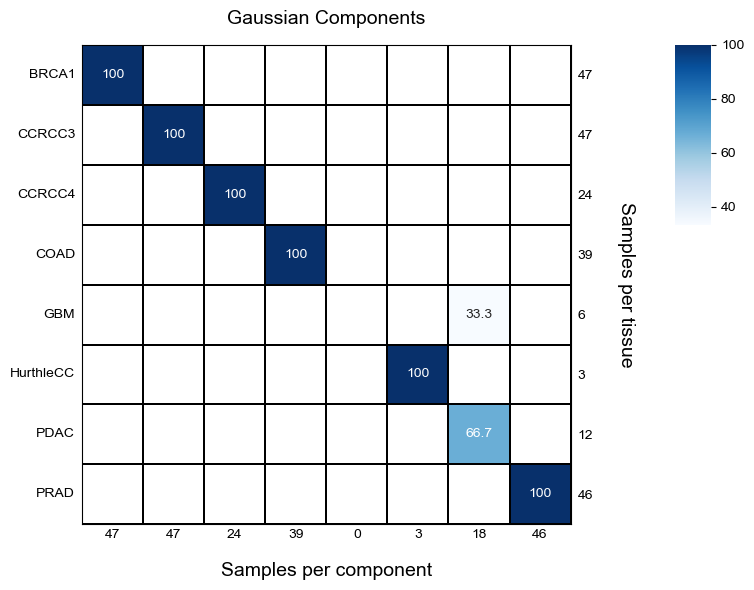

In [28]:
cm_norm = np.round(np.nan_to_num(cm / np.sum(cm, axis=0) * 100), decimals=1)
# np.sum(cm, axis=0)

class_lbls = list(cohorts.keys())
# sample_num_lbls = [len(cohorts[c]['sample_list']) for c in cohorts.keys()]
# sample_num_lbls = [37,37,19,31,4,2,9,36]
sample_num_lbls = [47, 47, 24, 39, 6, 3, 12, 46]
# sample_num_lbls = [47, 94, 118, 157, 169, 215]
# plt.rcParams["font.family"] = 'sans-serif'


zr_mask = np.where(cm_norm > 0, False, True)

fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm_norm, cmap='Blues',
            annot=True,
            fmt='g',
            xticklabels=np.sum(cm, axis=0),
            yticklabels=class_lbls,
            linewidths=0.1,
            mask=zr_mask,
            linecolor='black',
            ax=ax,
            cbar_kws={
                'pad': 0.15,
                'shrink': 0.375,
                'aspect': 5,
                'anchor': (0.0, 1.0)
            })

ax_y = ax.twinx()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.tick_params(axis='both', length=0)

ax_y.set_yticks(ax.get_yticks())
ax_y.set_ylim(ax.get_ylim())
ax_y.set_yticklabels(sample_num_lbls)
ax_y.tick_params(axis='y', length=0)

ax.set_xlabel('Samples per component', fontsize=14, labelpad=15)
ax_y.set_ylabel('Samples per tissue' , fontsize=14, labelpad=30, rotation=270)

ax.tick_params(  axis='y', direction='out', pad=5)
ax_y.tick_params(axis='y', direction='out', pad=5)

ax.set_title('Gaussian Components', pad=15, fontsize=14)

# fig.subplots_adjust(bottom=0.5)
plt.tight_layout()

### Figure X. PCA Code

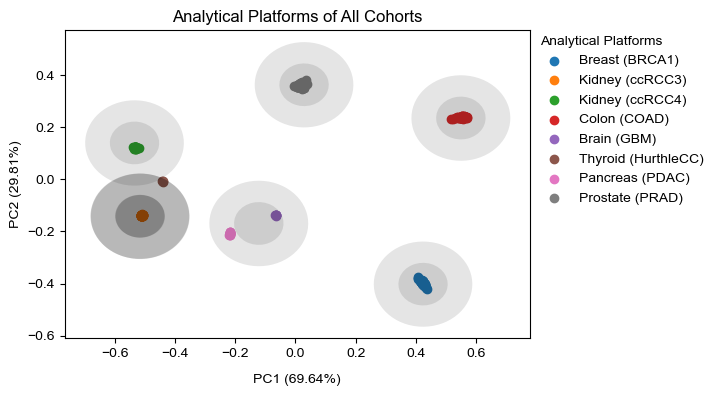

In [9]:
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
# import umap
means_and_reps = np.vstack((train_rep_final.z.detach().numpy(),dgd_final.gmm.means.detach().numpy()))
# means_and_reps = np.vstack((train_rep_final.z.detach().numpy(),dgd_final.gmm.means.detach().numpy()))
# pca = umap.UMAP(n_neighbors=2)
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(means_and_reps)
# pca_fit        = pca.fit_transform(train_rep_final.z.detach().numpy())
# pca_fit_means  = pca.transform(dgd_model.gmm.means.detach().numpy())
fig, ax = plt.subplots(figsize=(6,4))
# ax.scatter(pca_fit[0:37,0]   , pca_fit[0:37,1]   , label='BRCA1'    )
# ax.scatter(pca_fit[37:74,0]  , pca_fit[37:74,1]  , label='ccRCC3'     )
# ax.scatter(pca_fit[74:93,0]  , pca_fit[74:93,1]  , label='ccRCC4'   )
# ax.scatter(pca_fit[93:124,0] , pca_fit[93:124,1] , label='COAD'   )
# ax.scatter(pca_fit[124:128,0], pca_fit[124:128,1], label='GBM'      )
# ax.scatter(pca_fit[128:130,0], pca_fit[128:130,1], label='HurthleCC')
# ax.scatter(pca_fit[130:139,0], pca_fit[130:139,1], label='PDAC'     )
# ax.scatter(pca_fit[139:175,0], pca_fit[139:175,1], label='PRAD'     )

ax.scatter(pca_fit[0:47,0]   , pca_fit[0:47,1]   ,  label='Breast (BRCA1)'    )
ax.scatter(pca_fit[47:94,0]  , pca_fit[47:94,1]  ,  label='Kidney (ccRCC3)'     )
ax.scatter(pca_fit[94:118,0]  , pca_fit[94:118,1],  label='Kidney (ccRCC4)' )
ax.scatter(pca_fit[118:157,0] , pca_fit[118:157,1], label='Colon (COAD)' )
ax.scatter(pca_fit[157:163,0], pca_fit[157:163,1],  label='Brain (GBM)'      )
ax.scatter(pca_fit[163:166,0], pca_fit[163:166,1],  label='Thyroid (HurthleCC)')
ax.scatter(pca_fit[166:178,0], pca_fit[166:178,1],  label='Pancreas (PDAC)'     )
ax.scatter(pca_fit[178:224,0], pca_fit[178:224,1],  label='Prostate (PRAD)'     )

# idx_lcgc = np.r_[0:47, 157:163, 166:178, 178:224]
# idx_lc = np.r_[47:94, 94:118, 163:166]

# ax.scatter(pca_fit[idx_lcgc,0]   , pca_fit[idx_lcgc,1]   ,  label='LC-MS and GC-MS'    )
# ax.scatter(pca_fit[idx_lc,0]  , pca_fit[idx_lc,1]  ,  label='LC-MS'     )
# ax.scatter(pca_fit[118:157,0] , pca_fit[118:157,1], label='CE-TOFMS' )
# ax.scatter(pca_fit[94:118,0]  , pca_fit[94:118,1],  label='LC-MS' )
# ax.scatter(pca_fit[157:163,0], pca_fit[157:163,1],  label='LC-MS and GC-MS'      )
# ax.scatter(pca_fit[163:166,0], pca_fit[163:166,1],  label='LC-MS')
# ax.scatter(pca_fit[166:178,0], pca_fit[166:178,1],  label='LC-MS and GC-MS'     )
# ax.scatter(pca_fit[178:224,0], pca_fit[178:224,1],  label='LC-MS and GC-MS'     )

# ax.annotate('BRCA1', xy=(pca_fit[0,0], pca_fit[0, 1])        , ha='center', textcoords='offset points', xytext=(0,5))
# ax.annotate('ccRCC3', xy=(pca_fit[47,0], pca_fit[47, 1])     , ha='center', textcoords='offset points', xytext=(0,5))
# ax.annotate('ccRCC4', xy=(pca_fit[94,0], pca_fit[94, 1])     , ha='center', textcoords='offset points', xytext=(0,5))
# ax.annotate('COAD', xy=(pca_fit[118,0], pca_fit[118, 1])     , ha='center', textcoords='offset points', xytext=(0,5))
# ax.annotate('GBM', xy=(pca_fit[157,0], pca_fit[157, 1])      , ha='center', textcoords='offset points', xytext=(0,5))
# ax.annotate('HurthleCC', xy=(pca_fit[163,0], pca_fit[163, 1]), ha='center', textcoords='offset points', xytext=(0,5))
# ax.annotate('PDAC', xy=(pca_fit[166,0], pca_fit[166, 1])     , ha='center', textcoords='offset points', xytext=(0,5))
# ax.annotate('PRAD', xy=(pca_fit[178,0], pca_fit[178, 1])     , ha='center', textcoords='offset points', xytext=(0,5))

# ax.scatter(pca_fit[175:,0], pca_fit[175:,1], label='GMM Means', c='black', marker='*')
# ax.scatter(pca_fit[224:,0], pca_fit[224:,1], label='GMM Means', c='black', marker='*',)
# ax.scatter(pca_fit[0:19,0] , pca_fit[0:19,1] , label='Kidney 4'   )
# ax.scatter(pca_fit[19:28,0], pca_fit[19:28,1], label='Pancreas'     )
# ax.scatter(pca_fit[28:64,0], pca_fit[28:64,1], label='Prostate'     )
# ax.scatter(pca_fit[64:,0], pca_fit[64:,1], label='GMM Means', c='black', marker='*')

P = pca.components_
for x in range(0, dgd_final.gmm.n_comp):
    cov_2d = np.diag(torch.exp(dgd_final.gmm.log_var).detach().numpy()[x])
    # print(cov_2d)
    mean_2d = P @ (dgd_final.gmm.means.detach().numpy()[x] - pca.mean_)
    # mean_2d = pca_fit[175+x]
    cov_2d_projected = P @ cov_2d @ P.T

    vals, vecs = np.linalg.eigh(cov_2d_projected)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    
    std = 1.0
    w, h = 2 * std * np.sqrt(vals)
    ellipse = Ellipse(xy=mean_2d, width=w, height=h, angle=angle,
                    facecolor='black', alpha=0.1)
    ax.add_patch(ellipse)

    std = 2.0
    w, h = 2 * std * np.sqrt(vals)
    ellipse_2 = Ellipse(xy=mean_2d, width=w, height=h, angle=angle,
                    facecolor='black', alpha=0.1)
    ax.add_patch(ellipse_2)


# ax.scatter(pca_fit_means[:,0], pca_fit_means[:,1], label='Means', c='black'     )
ax.set_title('Analytical Platforms of All Cohorts')

ax.set_xlabel(f'PC1 ({(pca.explained_variance_ratio_[0] * 100):.2f}%)', labelpad=10)
ax.set_ylabel(f'PC2 ({(pca.explained_variance_ratio_[1] * 100):.2f}%)')
# ax.set_xlabel('UMAP D1')
# ax.set_ylabel('UMAP D2')
ax.legend(bbox_to_anchor=(1.40, 1.025),loc='upper right', fancybox=False, framealpha=0.0, title='Analytical Platforms', alignment='left')

In [32]:
# c_2d_list = list(cohorts.keys())
# c_2d_list = [c_2d_list[0:4], c_2d_list[4:8]]
# fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 5))
# plt.subplots_adjust(wspace=0.5, hspace=0.5)

# pca_test = PCA(n_components=2)
# idxs = [0, 37, 74, 93, 124, 128, 130, 139, 175]

# i = 0
# j = 0
# k = 0
# for c_list in c_2d_list:
#     for c in c_list:
#         samples = train_loader.dataset.metabolite_abundances[idxs[i]:idxs[i+1]]
#         pca_test = PCA(n_components=2)
#         pca_test_fit = pca_test.fit_transform(samples)

#         ax[j][k].set_xlabel(f'PC1 ({(pca_test.explained_variance_ratio_[0] * 100):.2f}%)')
#         ax[j][k].set_ylabel(f'PC2 ({(pca_test.explained_variance_ratio_[1] * 100):.2f}%)')
#         ax[j][k].scatter(pca_test_fit[:, 0], pca_test_fit[:, 1], label=c)
#         ax[j][k].set_title(c)
        
#         i += 1
#         k += 1
#     j += 1
#     k = 0

# plt.suptitle("PCA - Training Samples")
# plt.show()

In [33]:
# c_2d_list = list(cohorts.keys())
# c_2d_list = [c_2d_list[0:4], c_2d_list[4:8]]
# fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 5))
# plt.subplots_adjust(wspace=0.5, hspace=0.5)

# pca_test = PCA(n_components=2)
# idxs = [0, 47, 94, 118, 157, 163, 166, 178, 224]

# i = 0
# j = 0
# k = 0
# for c_list in c_2d_list:
#     for c in c_list:

#         samples = df_log.to_numpy()[idxs[i]:idxs[i+1]]
#         pca_test = PCA(n_components=2)
#         pca_test_fit = pca_test.fit_transform(samples)

#         ax[j][k].set_xlabel(f'PC1 ({(pca_test.explained_variance_ratio_[0] * 100):.2f}%)')
#         ax[j][k].set_ylabel(f'PC2 ({(pca_test.explained_variance_ratio_[1] * 100):.2f}%)')
#         ax[j][k].scatter(pca_test_fit[:, 0], pca_test_fit[:, 1], label=c)
#         ax[j][k].set_title(c)
        
#         i += 1
#         k += 1
#     j += 1
#     k = 0

# plt.suptitle("PCA - All Samples")
# plt.show()

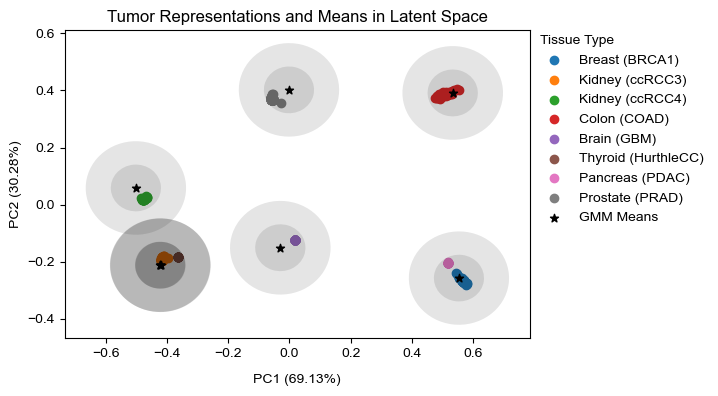

In [ ]:
pca_tumor = PCA(n_components=2)
means_and_tumor_reps = np.vstack((tumor_rep_final.detach(), dgd_model.gmm.means.detach().numpy()))
pca_fit = pca_tumor.fit_transform(means_and_tumor_reps)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(pca_fit[0:61,0]  , pca_fit[0:61,1]  ,     label='Breast (BRCA1)'    )
ax.scatter(pca_fit[61:128,0]  , pca_fit[61:128,1]  , label='Kidney (ccRCC3)'     )
ax.scatter(pca_fit[128:180,0]  , pca_fit[128:180,1], label='Kidney (ccRCC4)' )
ax.scatter(pca_fit[180:217,0] , pca_fit[180:217,1] , label='Colon (COAD)' )
ax.scatter(pca_fit[217:291,0], pca_fit[217:291,1],   label='Brain (GBM)'      )
ax.scatter(pca_fit[291:319,0], pca_fit[291:319,1],   label='Thyroid (HurthleCC)')
ax.scatter(pca_fit[319:346,0], pca_fit[319:346,1],   label='Pancreas (PDAC)'     )
ax.scatter(pca_fit[346:437,0], pca_fit[346:437,1],   label='Prostate (PRAD)'     )
ax.scatter(pca_fit[437:,0], pca_fit[437:,1], label='GMM Means', c='black', marker='*')
ax.set_title('Tumor Representations and Means in Latent Space')


P = pca_tumor.components_
for x in range(0, dgd_model.gmm.n_comp):
    cov_2d = np.diag(torch.exp(dgd_model.gmm.log_var).detach().numpy()[x])
    # print(cov_2d)
    mean_2d = P @ (dgd_model.gmm.means.detach().numpy()[x] - pca_tumor.mean_)
    # mean_2d = pca_fit[175+x]
    cov_2d_projected = P @ cov_2d @ P.T

    vals, vecs = np.linalg.eigh(cov_2d_projected)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    
    std = 1.0
    w, h = 2 * std * np.sqrt(vals)
    ellipse = Ellipse(xy=mean_2d, width=w, height=h, angle=angle,
                      facecolor='black', alpha=0.1)
    ax.add_patch(ellipse)

    std = 2.0
    w, h = 2 * std * np.sqrt(vals)
    ellipse_2 = Ellipse(xy=mean_2d, width=w, height=h, angle=angle,
                      facecolor='black', alpha=0.1)
    ax.add_patch(ellipse_2)

ax.set_xlabel(f'PC1 ({(pca_tumor.explained_variance_ratio_[0] * 100):.2f}%)', labelpad=10)
ax.set_ylabel(f'PC2 ({(pca_tumor.explained_variance_ratio_[1] * 100):.2f}%)')
ax.legend(bbox_to_anchor=(1.40, 1.025),loc='upper right', fancybox=False, framealpha=0.0, title='Tissue Type', alignment='left')

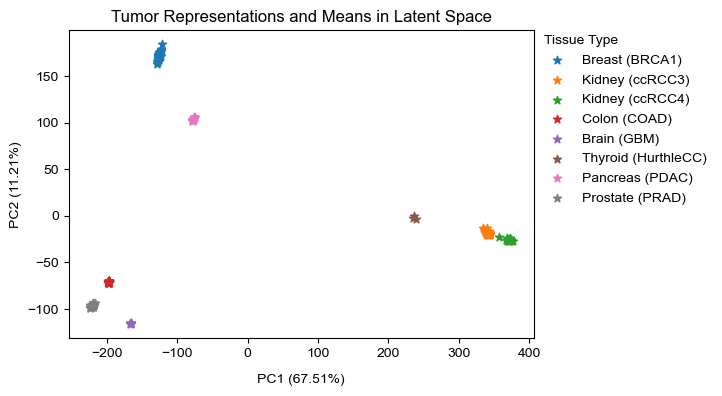

In [36]:
pca_platform = PCA(n_components=2)
fit_platform = pca_platform.fit_transform(np_normal_log)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(fit_platform[0:47,0]   , fit_platform[0:47,1]   , marker='*'  ,label='Breast (BRCA1)'    )
ax.scatter(fit_platform[47:94,0]  , fit_platform[47:94,1]  , marker='*'  ,label='Kidney (ccRCC3)'     )
ax.scatter(fit_platform[94:118,0]  ,fit_platform[94:118,1] , marker='*'  ,label='Kidney (ccRCC4)' )
ax.scatter(fit_platform[118:157,0] ,fit_platform[118:157,1], marker='*'  ,label='Colon (COAD)' )
ax.scatter(fit_platform[157:163,0], fit_platform[157:163,1], marker='*'  ,label='Brain (GBM)'      )
ax.scatter(fit_platform[163:166,0], fit_platform[163:166,1], marker='*'  ,label='Thyroid (HurthleCC)')
ax.scatter(fit_platform[166:178,0], fit_platform[166:178,1], marker='*'  ,label='Pancreas (PDAC)'     )
ax.scatter(fit_platform[178:224,0], fit_platform[178:224,1], marker='*'  ,label='Prostate (PRAD)'     )
ax.set_title('Tumor Representations and Means in Latent Space')

ax.set_xlabel(f'PC1 ({(pca_platform.explained_variance_ratio_[0] * 100):.2f}%)', labelpad=10)
ax.set_ylabel(f'PC2 ({(pca_platform.explained_variance_ratio_[1] * 100):.2f}%)')
ax.legend(bbox_to_anchor=(1.40, 1.025),loc='upper right', fancybox=False, framealpha=0.0, title='Tissue Type', alignment='left')

## V. Hyperparameter Grid Search (OPTIONAL)

TODO: Get updated hyperparameter search script from the server

In [ ]:
import wandb

def grid_search(config=None):
    with wandb.init(config=config):
        c = wandb.config
        
        skf = StratifiedKFold(n_splits=3)

        for i, (ti, vi) in enumerate(skf.split(df_log.to_numpy(), np.array(df_lbls))):
            pass

        dgd_cand = model.MetaboDGD(
            latent_dim=c.latent_dim,
            output_dim=df_log.shape[1],
            dec_hidden_layers_dim=[500, 1500],
            dec_output_prediction_type='mean',
            dec_output_activation_type='softplus',
            n_comp=8,
            cm_type='diagonal',
            softball_radius=c.softball_radius,
            softball_sharpness=c.softball_sharpness,
            gaussian_mean=c.gaussian_mean,
            gaussian_stddev=c.gaussian_stddev,
            dirichlet_alpha=c.dirichlet_alpha
        )

        dgd_cand, train_rep, test_rep, history, cm = train.train_dgd(
            dgd_model=dgd_cand,
            train_loader=train_loader,
            validation_loader=test_loader,
            n_epochs=250,
            lr_schedule_epochs=None,
            lr_schedule=[1e-4, 1e-3, 1e-2], # dec, rep, gmm
            optim_betas=[0.5, 0.7],
            wd=1e-5,
        )

        wandb.log({"validation_reconstruction_loss": history.iloc[-1]['val_loss'],
                   "cluster_acc": history.iloc[-1]['cluster_acc']})


def execute_grid_search():
    sweep_config = {
        'method': 'grid',
        'metric': {
            'name': 'cluster_acc',
            'goal': 'maximize'
        },
        'parameters': {
            'latent_dim': {
                'values': [20, 30],
            },
            'dirichlet_alpha': {
                'values': [0.5, 1.0],
            },
            'softball_radius': {
                'values': [3, 5, 7],
            },
            'softball_sharpness': {
                'values': [5, 10],
            },
            'gaussian_mean': {
                'values': [-6.0, -5.0],
            },
            'gaussian_stddev': {
                'values': [0.01, 0.25, 0.50]
            }
        }
    }

    sweep_id = wandb.sweep(
        sweep=sweep_config,
        project="my-first-project"
    )

    wandb.agent(
        sweep_id=sweep_id,
        function=grid_search
    )


# execute_grid_search()

In [ ]:
skf = StratifiedKFold(n_splits=3)
ave_cluster_acc = 0
ave_val_recon_loss = 0

for i, (ti, vi) in enumerate(skf.split(np_normal_log, np_normal_lbls)):
    ## Initialize train and validation Dataloaders
    train_loader, validation_loader = \
        data.create_dataloaders(np_train_abun=np_normal_log[ti],np_train_lbls=np_normal_lbls[ti],
                                np_validation_abun=np_normal_log[vi], np_validation_lbls=np_normal_lbls[vi],
                                batch_size=32)
    
    
    ## Initialize DGD model
    dgd_model = \
        model.MetaboDGD(
            latent_dim=50,
            output_dim=np_normal_log.shape[1],
            dec_hidden_layers_dim=[500, 1500],
            dec_output_prediction_type='mean',
            dec_output_activation_type='softplus',
            n_comp=8,
            cm_type='diagonal',
            softball_radius=5,
            softball_sharpness=10,
            gaussian_mean=-5.0,
            gaussian_stddev=0.25,
            dirichlet_alpha=2.0,
            
        )

    dgd_model, train_rep, val_rep, history, cm = \
        train.train_dgd(
            dgd_model=dgd_model,
            train_loader=train_loader,
            validation_loader=validation_loader,
            n_epochs=200,
            lr_schedule_epochs=None,
            lr_schedule=[1e-4, 1e-3, 1e-2], # dec, rep, gmm
            optim_betas=[0.5, 0.7],
            wd=1e-4,
        )
    
    ave_cluster_acc += history.iloc[-1]['cluster_acc']
    ave_val_recon_loss += history.iloc[-1]['val_loss']

    train.get_history_plot(history, inc_gmm_acc=True, with_val_plot=True)
    ans = input("Continue?")

ave_cluster_acc /= 3
ave_val_recon_loss /= 3